# 14-14. 프로젝트: 한국어 데이터로 챗봇 만들기

## Step 0. 환경설정 및 라이브러리 Import

In [1]:
import os
import re
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

print(tf.__version__)

2.6.0


## Step 1. 데이터 수집하기

In [2]:
# ! mkdir -p ~/aiffel/transformer_chatbot/data/
# ! ln -s ~/data/* ~/aiffel/transformer_chatbot/data/

In [3]:
data_file_path = os.getenv('HOME') + '/aiffel/transformer_chatbot/data/'
data_file = data_file_path + 'ChatbotData.csv'

questions, answers = [], []
with open(data_file,'r',encoding="utf-8") as f:
    for line in f.read().splitlines():
        questions.append(line.split(',')[0:1][0])
        answers.append(line.split(',')[1:2][0])

print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))
print('질문 처음 5개')
print(questions[:5])
print('질문 끝 5개')
print(questions[-5:])
print('답변 처음 5개')
print(answers[:5])
print('답변 끝 5개')
print(answers[-5:])

전체 질문 수 : 11824
전체 답변 수 : 11824
질문 처음 5개
['Q', '12시 땡!', '1지망 학교 떨어졌어', '3박4일 놀러가고 싶다', '3박4일 정도 놀러가고 싶다']
질문 끝 5개
['훔쳐보는 것도 눈치 보임.', '훔쳐보는 것도 눈치 보임.', '흑기사 해주는 짝남.', '힘든 연애 좋은 연애라는게 무슨 차이일까?', '힘들어서 결혼할까봐']
답변 처음 5개
['A', '하루가 또 가네요.', '위로해 드립니다.', '여행은 언제나 좋죠.', '여행은 언제나 좋죠.']
답변 끝 5개
['티가 나니까 눈치가 보이는 거죠!', '훔쳐보는 거 티나나봐요.', '설렜겠어요.', '잘 헤어질 수 있는 사이 여부인 거 같아요.', '도피성 결혼은 하지 않길 바라요.']


#### 테스트를 위해서 10%의 샘플을 분리해 둠

In [4]:
questions, test_Q, answers, test_A = train_test_split(questions, answers, test_size=0.1, random_state=32)

print('훈련 질문 수 :', len(questions))
print('훈련 답변 수 :', len(answers))
print('테스트 질문 수 :', len(test_Q))
print('테스트 답변 수 :', len(test_A))

훈련 질문 수 : 10641
훈련 답변 수 : 10641
테스트 질문 수 : 1183
테스트 답변 수 : 1183


## Step 2. 데이터 전처리하기

In [5]:
# 첫번째 행 데이터는 column name 이므로 삭제
del questions[0]
del answers[0]

print('전체 질문 수 :', len(questions))
print('전체 답변 수 :', len(answers))
print('질문 처음 5개')
print(questions[:5])
print('질문 끝 5개')
print(questions[-5:])
print('답변 처음 5개')
print(answers[:5])

전체 질문 수 : 10640
전체 답변 수 : 10640
질문 처음 5개
['나만 이상해졌어', '썸타는거 친구한테 이야기 한고 싶다.', '내가 생각했던 사람이 맞는지 확신이 안들어', '후폭풍이 올까 두려운데.!', '기차여행 가고 싶어']
질문 끝 5개
['저 좀 웃게 해주세요', '좋아하는 사람이 부담스러워할까봐 친구들 여럿이서 보는데.', '내가 좋아하는지 그 애가 아예 몰라.', '뭘 챙겨주면 좋을까', '잘 먹는 여자가 좋아']
답변 처음 5개
['그 말을 한 사람이 가장 이상할 거예요.', '확실해지면 이야기해도 늦지 않아요.', '새로운 모습을 봤나봐요.', '그냥 지금 우세요.', '꿈꾸던 여행이네요.']


#### 첫 행이 삭제되었다.

In [6]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "여행은 언제나 좋죠." => "여행은 언제나 좋죠 ."와 같이 한칸 띄움
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'"', '', sentence)  # 쌍따옴표 " 제거
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = sentence.strip()
    return sentence

In [7]:
# 전처리 함수 테스트
text = '  이것은 "컴퓨터"라고   합니다.    '
print('처리전 : '+'S'+text+'E')
print('처리후 : '+'S'+preprocess_sentence(text)+'E')

처리전 : S  이것은 "컴퓨터"라고   합니다.    E
처리후 : S이것은 컴퓨터라고 합니다 .E


#### 마침표가 본문에서 한칸 떨어졌고, 쌍따옴표(")가 삭제되었으며, 여러개의 공백이 한개로 합쳐졌고, 문장 앞/뒤의 공백이 삭제되었다.

## Step 3. SubwordTextEncoder 사용하기

In [8]:
# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(questions + answers, target_vocab_size=2**13)

In [9]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]

In [10]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [7568]
END_TOKEN의 번호 : [7569]


In [11]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

7570


In [12]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [637, 3308, 4909, 1012]
정수 인코딩 후의 21번째 답변 샘플: [1903, 6001, 1, 7358]


#### 샘플의 최대 길이 정하기

질문의 최소 길이 : 1
질문의 최대 길이 : 15
질문의 평균 길이 : 3.5717105263157896
답변의 최소 길이 : 0
답변의 최대 길이 : 21
답변의 평균 길이 : 3.6795112781954886


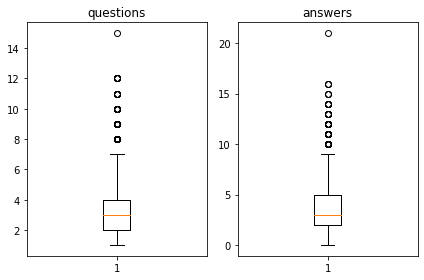

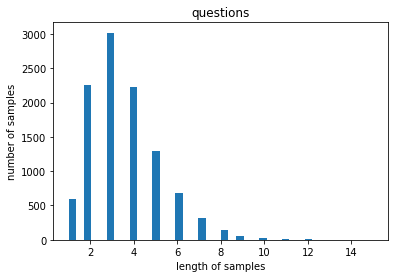

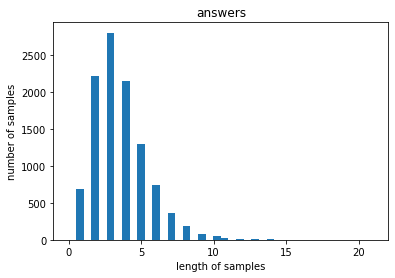

In [13]:
# 길이 분포 출력

questions_len = [len(s.split()) for s in questions]
answers_len = [len(s.split()) for s in answers]

print('질문의 최소 길이 : {}'.format(np.min(questions_len)))
print('질문의 최대 길이 : {}'.format(np.max(questions_len)))
print('질문의 평균 길이 : {}'.format(np.mean(questions_len)))
print('답변의 최소 길이 : {}'.format(np.min(answers_len)))
print('답변의 최대 길이 : {}'.format(np.max(answers_len)))
print('답변의 평균 길이 : {}'.format(np.mean(answers_len)))

plt.subplot(1,2,1)
plt.boxplot(questions_len)
plt.title('questions')
plt.subplot(1,2,2)
plt.boxplot(answers_len)
plt.title('answers')
plt.tight_layout()
plt.show()

plt.title('questions')
plt.hist(questions_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('answers')
plt.hist(answers_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [14]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
# 위 boxplot 참조, questions 7, answers 9 중 큰 9를 선택
MAX_LENGTH = 9

In [15]:
cnt = 0
for s in answers:
    if(len(s.split()) <= MAX_LENGTH):
        cnt = cnt + 1
print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(MAX_LENGTH, (cnt / len(answers))))

전체 샘플 중 길이가 9 이하인 샘플의 비율: 0.9889097744360902


In [16]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
  
    for (sentence1, sentence2) in zip(inputs, outputs):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 MAX_LENGTH 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
  
    # 최대 길이 MAX_LENGTH로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
    return tokenized_inputs, tokenized_outputs

In [17]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 7570
필터링 후의 질문 샘플 개수: 6916
필터링 후의 답변 샘플 개수: 6916


In [18]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

## Step 4. 모델 구성하기

### 4-1. 어텐션

In [19]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output

In [20]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

### 4-2. 마스킹

In [21]:
# 다음은 패딩 마스킹을 구현한 함수입니다.
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 4-3. 인코더

In [22]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

In [23]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

In [24]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

### 4-4. 디코더

In [25]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

In [26]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

### 4-5. Transformer 함수 정의

In [27]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

### 4-6. 모델 생성

In [28]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2  # 인코더와 디코더의 층의 개수
D_MODEL = 256   # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 16  # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512     # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.0   # 드롭아웃의 비율

model = transformer(vocab_size=VOCAB_SIZE,
                    num_layers=NUM_LAYERS,
                    units=UNITS,
                    d_model=D_MODEL,
                    num_heads=NUM_HEADS,
                    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    2992128     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

### 4-7. 손실 함수(Loss function) 작성

In [29]:
def loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    loss = tf.multiply(loss, mask)

    return tf.reduce_mean(loss)

### 4-8. 커스텀 된 학습률(Learning rate)

In [30]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

### 4-9. 모델 컴파일

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])

### 4-10. 훈련하기

In [32]:
EPOCHS = 50
history = model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/50
109/109 [==============================] - 9s 25ms/step - loss: 5.9904 - accuracy: 0.1155
Epoch 2/50
109/109 [==============================] - 3s 24ms/step - loss: 5.2068 - accuracy: 0.2365
Epoch 3/50
109/109 [==============================] - 3s 24ms/step - loss: 4.4761 - accuracy: 0.2372
Epoch 4/50
109/109 [==============================] - 3s 24ms/step - loss: 3.9139 - accuracy: 0.2415
Epoch 5/50
109/109 [==============================] - 3s 25ms/step - loss: 3.5463 - accuracy: 0.2491
Epoch 6/50
109/109 [==============================] - 3s 24ms/step - loss: 3.2860 - accuracy: 0.2625
Epoch 7/50
109/109 [==============================] - 3s 25ms/step - loss: 3.0360 - accuracy: 0.2852
Epoch 8/50
109/109 [==============================] - 3s 24ms/step - loss: 2.7706 - accuracy: 0.3203
Epoch 9/50
109/109 [==============================] - 3s 25ms/step - loss: 2.4731 - accuracy: 0.3620
Epoch 10/50
109/109 [==============================] - 3s 24ms/step - loss: 2.1481 - accura

### 4-11. 훈련결과 시각화

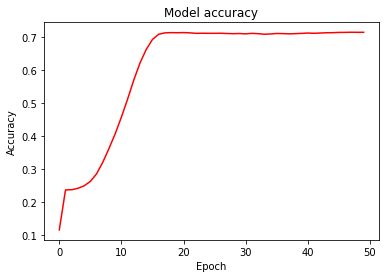

In [33]:
plt.plot(history.history['accuracy'], 'r')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

## Step 5. 모델 평가하기

In [34]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [35]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    return predicted_sentence

In [36]:
for i in range(200, 210):
    print('-'*25)
    print('질문 입력 : {}'.format(test_Q[i]))
    print('정답 출력 : {}'.format(test_A[i]))
    print('예측 출력 : {}'.format(sentence_generation(test_Q[i])))

-------------------------
질문 입력 : 일이 익숙해 지지 않네
정답 출력 : 조금만 더 힘내세요.
예측 출력 : 조금만 더 힘내세요.
-------------------------
질문 입력 : 자꾸 거짓말 하게 되네
정답 출력 : 진실된 말을 하려고 노력해보세요.
예측 출력 : 선의의 거짓말이길 바라요.
-------------------------
질문 입력 : 버려줘서 고마워.
정답 출력 : 당신이 버렸다고 생각하는 건 어떨까요.
예측 출력 : 쉽지 않을 결정이었을 텐데.
-------------------------
질문 입력 : 옷장이 점점 줄어들어
정답 출력 : 지난 계절 옷을 잘 정리해 보세요.
예측 출력 : 큰일이네요.
-------------------------
질문 입력 : 안주 추천 좀
정답 출력 : 살 안 찌는 게 좋을 것 같아요.
예측 출력 : 힘들겠어요.
-------------------------
질문 입력 : 스타트업에 가도 될까?
정답 출력 : 모 아니면 도예요.
예측 출력 : 직접적이든 간접적이든 의사를 확실히 밝혀보세요.
-------------------------
질문 입력 : 사랑은 영원해?
정답 출력 : 사랑은 한 순간이면서 영원한거 같아요.
예측 출력 : 믿으면 이루어져요.
-------------------------
질문 입력 : 술 많이 마셔야지
정답 출력 : 적당히 드세요.
예측 출력 : 저랑 한 잔 해요.
-------------------------
질문 입력 : 셀프웨딩이 유행이래
정답 출력 : 혼자 준비하기는 조금 벅찰텐대요.
예측 출력 : 쉽지 않을거예요.
-------------------------
질문 입력 : 서류에서 떨어지다니
정답 출력 : 합격하는 곳이 있을 거예요.
예측 출력 : 될 거예요.


#### 10,640개의 샘플로 3분정도 훈련한 결과치곤 제법 맥락에 맞는 답을 생성하였다. 
#### 정답으로 제시된 답변과 다르더라도 오히려 더 좋은 답변도 있다.

## 회고
### 이번 프로젝트에서 어려웠던 점

Transformer 모델/Attention의 개념은 교재만 읽고는 이해하기가 어렵다. 

### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

그 유명한 BERT도 Transformer 모델을 활용하여 사전학습을 적용했다는 사실에 Transformer 모델의 우수성을 알게 되었다.

### 루브릭 평가 지표를 맞추기 위해 시도한 것들

1. 최대 문장길이를 boxplot을 이용하여 적용했다. Accuracy 향상에 많은 기여를 하였다.
2. Hyperparameter인 NUM_LAYERS, D_MODEL, NUM_HEADS, UNITS, DROPOUT등을 다양한 조합으로 바꾸어 보았다.

### 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

충분히 달성했다고 생각된다.

### 자기 다짐

Transformer 모델/Attention의 개념에 대하여 좀 더 공부해야 하겠다.